In [1]:
# Tutorial: "A tour of Data Assimilation methods"
# Model: Lorenz-63
# DA Methods: Nudging, 3D-Var, 4D-Var, Particle Filter, EnKF, Hybrid
import numpy as np
from class_lorenz96_mdl import LORENZ96
from class_state_vec import state_vector
from class_obs import obs_da
from class_da_sys import da_system
import copy
from copy import deepcopy
import random
import sys
import math
import matplotlib.pyplot as plt
from scipy import ndimage

#-----------------------------------------------------------------------
# Read the da system object
#-----------------------------------------------------------------------
name = 'x_analysis'
infile = name+'_init.pkl'
das = da_system()
das = das.load(infile)#         
print(das)

#-----------------------------------------------------------------------
# Initialize the ensemble
#-----------------------------------------------------------------------
xa = das.x0
#np.random.seed(2)
#Xa = das.initEns(xa,mu=das.ens_bias_init,sigma=das.ens_sigma_init,edim=das.edim, separate = 'no')
Xa = das.initEns(xa,mu=das.ens_bias_init,sigma=1,edim=das.edim, separate = 'no')

print('ensemble dimension = ')
print(das.edim)
print('initial bias = ')
print(das.ens_bias_init)
print('initial standard deviation = ')
print(das.ens_sigma_init)


#-----------------------------------------------------------------------
# Get the nature run trajectory
#-----------------------------------------------------------------------
sv = das.getStateVector()
x_nature = sv.getTrajectory()
x_nature = x_nature[:,::5]
H = das.getH()
R = das.getR()

#-----------------------------------------------------------------------
# Get the S-I1-I2-R observations via the obs_da object
#-----------------------------------------------------------------------
obs = das.getObsData()
y_obs = obs.getVal()
y_pts = obs.getPos()
y_err = obs.getErr()


#-----------------------------------------------------------------------
# Initialize the timesteps
#-----------------------------------------------------------------------
t_nature = sv.getTimes()

acyc_step = das.acyc_step  # (how frequently to perform an analysis)
dtau = das.dtau
dt_output = das.dt
fcst_step= das.fcst_step
fcst_dt = das.fcst_dt
maxit = das.maxit
xdim = das.xdim
ydim = das.ydim
dt = 0.005
#-----------------------------------------------------------------------
# Choose DA method:
#-----------------------------------------------------------------------
#das.setMethod('EnKF')
method = das.getMethod() 

#-----------------------------------------------------------------------
# Conduct data assimilation process
#-----------------------------------------------------------------------
#
DA_count = 0
yo_hos = 0
flag = True
xa_history = np.hstack((np.zeros([maxit,das.xdim]),np.zeros([maxit,das.xdim])))
xa_history[:] = np.nan
KH_history = []
KH_idx = []

Xa_history = np.zeros([maxit, das.xdim, das.edim])
Xf_history = np.zeros([maxit, das.xdim, das.edim])

Xa_history[0,:,:] = Xa
stop #no need to do this again, use the saved data. If you have time, you can do this again.
for i in range(0,maxit-acyc_step,acyc_step):
  t = np.arange(i,i+acyc_step + 0.05,0.1)
  for s in range(len(t)):
    t[s] = int(1000*(t[s] / 20)+0.05)/1000
  t_output = t
  
  yo = y_obs[:, i+acyc_step]
  yp = y_pts[:, i+acyc_step]

  Xf = np.zeros_like(Xa) # #states * edim
  
  xf_4d = 0
  smd = LORENZ96(N = 40, F = 8)
  
  xf_4d_box= np.zeros((das.edim, das.xdim, len(t)))
  
  for k in range(das.edim):
    #xf_4d_k = smd.run(Xa[:,k].A1, t, t_output) # A1:flatten the kth column of Xa
    #xf_4d_k = xf_4d_k.y # xdim * #(t_output)
    xf_4d_k = smd.run_rk4(t[0], t[-1], dt, Xa[:,k].A1)
    xf_4d_k = xf_4d_k.T
    xf_4d_box[k,:,:] = xf_4d_k    
    Xf[:,k] = np.matrix(xf_4d_k[:,-1]).T
  
  Xf_history[i+acyc_step,:,:] = Xf


  #----------------------------------------------
  # Compute analysis_state
  #----------------------------------------------
  local = 19
  yo_loc = np.zeros(2*local+1)
  Yb_loc = np.zeros((2*local+1,das.edim))
  ym_loc = np.zeros((2*local+1,1))
  
  Yb = np.dot(H,Xf)
  yo = np.matrix(yo).flatten().T
  ym = np.mean(Yb, axis = 1)
  xm = np.mean(Xf,axis=1)
  Xb = Xf - np.matlib.repmat(xm, 1, das.edim)
  Yb = Yb - np.matlib.repmat(ym, 1, das.edim) 
  Xa = np.zeros((xdim,das.edim))
  

  for b in range(xdim):
    ind = np.arange(b-local,b+local+1)
    ind = (ind + 40)%40
    nn = 0
    for bb in ind:
        yo_loc[nn] = yo[bb]
        Yb_loc[nn,:] = Yb[bb,:]
        ym_loc[nn] = ym[bb]
        nn = nn + 1
    Xb_loc = Xb[b,:]
    xm_loc = xm[b]
    Xa_loc, KH_loc = das.compute_analysis(Xb_loc,yo_loc,Yb_loc,ym_loc,xm_loc)
    Xa[b,:] = Xa_loc
  Xa = np.matrix(Xa)
    
  #Xa, KH = das.compute_analysis(Xf,yo)   # (#state+#para) * (#esemble)
  


  Xa_history[i+acyc_step,:,:] = Xa
  xa = np.mean(Xa,axis=1)
  xa = xa.T

  Xa_sd_comp = np.zeros((das.xdim,1))
  Xa_sd_comp =  np.std(Xa, axis = 1).T

  xa_history[i+acyc_step,:] = np.hstack((xa,Xa_sd_comp))

  # Archive the analysis
  
  DA_count = DA_count + 1
  print(DA_count)
  # Archive the KH matrix
  #KH_history.append(deepcopy(KH))
  #KH_idx.append(i+acyc_step)
Xa_predict_ini= Xa
#CUT to next block



xdim=  40
ydim=  40
x0=  [ 1.94757715  8.26844895  6.52229789  5.45856885  2.05486938 -5.65751587
  1.39186799  1.03628549  8.79215157  1.20477322 -1.1704235   4.02916572
  9.18215603  8.29929937  4.72876505  0.43399091 -0.18400331  1.13323613
  5.32712695  3.52626656  0.82417844  4.17704375  7.91069355  2.18867489
  4.11372222  2.72803286  1.086051    2.89296598  7.37458279  7.28059258
 -3.9507817   1.29280407  3.56581138  0.5507535   2.63868015  3.24319956
  4.2741164   6.70039374 -2.30268975 -2.05067079]
t0=  0.0
dt=  0.05
t= [0.00000e+00 5.00000e-02 1.00000e-01 ... 7.29985e+03 7.29990e+03
 7.29995e+03]
acyc_step= 1
dtau=  0.05
fcst_step=  1
fcst_dt= 0.05
B = 
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
H = 
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
state_vecto

NameError: name 'stop' is not defined

In [2]:
#put all fcst error together
import glob
import natsort

path = 'fcst_rmse_store_*.txt' # sorry I forgot to copy these data before I return the PC to the institute, but it does not hurt the result.
files = glob.glob(path)
numb = 0
for file in natsort.natsorted(files):
    print(file)
    with open(file, "rb") as fp:   # Unpickling
        fcst_history = pickle.load(fp)
    if numb < 1:
        fcst_rmse_store = fcst_history
    else:
        fcst_rmse_store = np.vstack((fcst_rmse_store,fcst_history))
    numb = numb +1



ModuleNotFoundError: No module named 'natsort'

In [33]:
np.mean(fcst_rmse_store, axis = 0)

array([0.19888507, 0.2177817 , 0.23985927, 0.2649327 , 0.29284814,
       0.3235673 , 0.35718236, 0.39389373, 0.43396474, 0.47763685,
       0.52506363, 0.57630295, 0.63130984, 0.68991865, 0.7518648 ,
       0.81680474, 0.88435908, 0.95417582, 1.02594912, 1.0994163 ,
       1.1743104 , 1.25031482, 1.32708006, 1.40425645, 1.4815212 ,
       1.55858077, 1.63518672, 1.71115776, 1.78633795, 1.86052476,
       1.933511  , 2.0051662 , 2.07542569, 2.14421178, 2.21141568,
       2.27692241, 2.34062435, 2.40245403, 2.4624133 , 2.52053511,
       2.57679882, 2.63115441, 2.68359496, 2.73414869, 2.78285196,
       2.82973269, 2.87480165, 2.9180713 , 2.959562  , 2.99927106,
       3.03721134, 3.07348459, 3.1082268 , 3.14145228, 3.17310304,
       3.20318874, 3.23179528, 3.2590571 , 3.28509043, 3.30994049,
       3.33356882, 3.35594038, 3.37710881, 3.39718411, 3.41628188,
       3.43450324, 3.45189885, 3.46849444, 3.48432985, 3.49944269,
       3.51383638, 3.52747086, 3.54030769, 3.55236478, 3.56371

In [3]:
plt.figure(figsize = (12,5))
plt.plot(np.mean(fcst_rmse_store, axis = 0))
plt.ylabel('forecast RMSE', fontsize = 15)
plt.xlabel('forecast length (day)', fontsize = 15)
plt.xticks(np.arange(0,121,8), np.arange(0,31,2))
plt.grid(color = 'grey', linestyle = ':', linewidth = 0.5)
plt.title('averaged forecast error',fontsize = 15)
plt.savefig('averaged_fcst_err', bbox_inches = 'tight')

NameError: name 'fcst_rmse_store' is not defined

<Figure size 1200x500 with 0 Axes>

In [19]:
import pickle
#with open("6_h_Xf_history.txt", "rb") as fp:   # Unpickling
#    Xf_history = pickle.load(fp)
with open("24_h_inf_1.5_Xa_history.txt", "rb") as fp:   # Unpickling
    Xa_history = pickle.load(fp)


In [20]:
#when you start from a bread down, please load the documents first
from class_state_vec import state_vector
from class_da_sys import da_system
sv = state_vector()
das = da_system()
#Xf_history = sv.load('6_h_Xf_history.txt')
#das = das.load('6_h_x_analysis_EnKF.pkl')
sv2 = das.getStateVector()
#xa_history = sv2.getTrajectory()
#Xa_history = sv2.getXaTrajectory() 
name = 'x_analysis'
infile = name+'_init.pkl'
das = da_system()
das = das.load(infile)#   
sv = das.getStateVector()
#x_nature = sv.getTrajectory()
acyc_step = das.acyc_step
print(acyc_step)

1


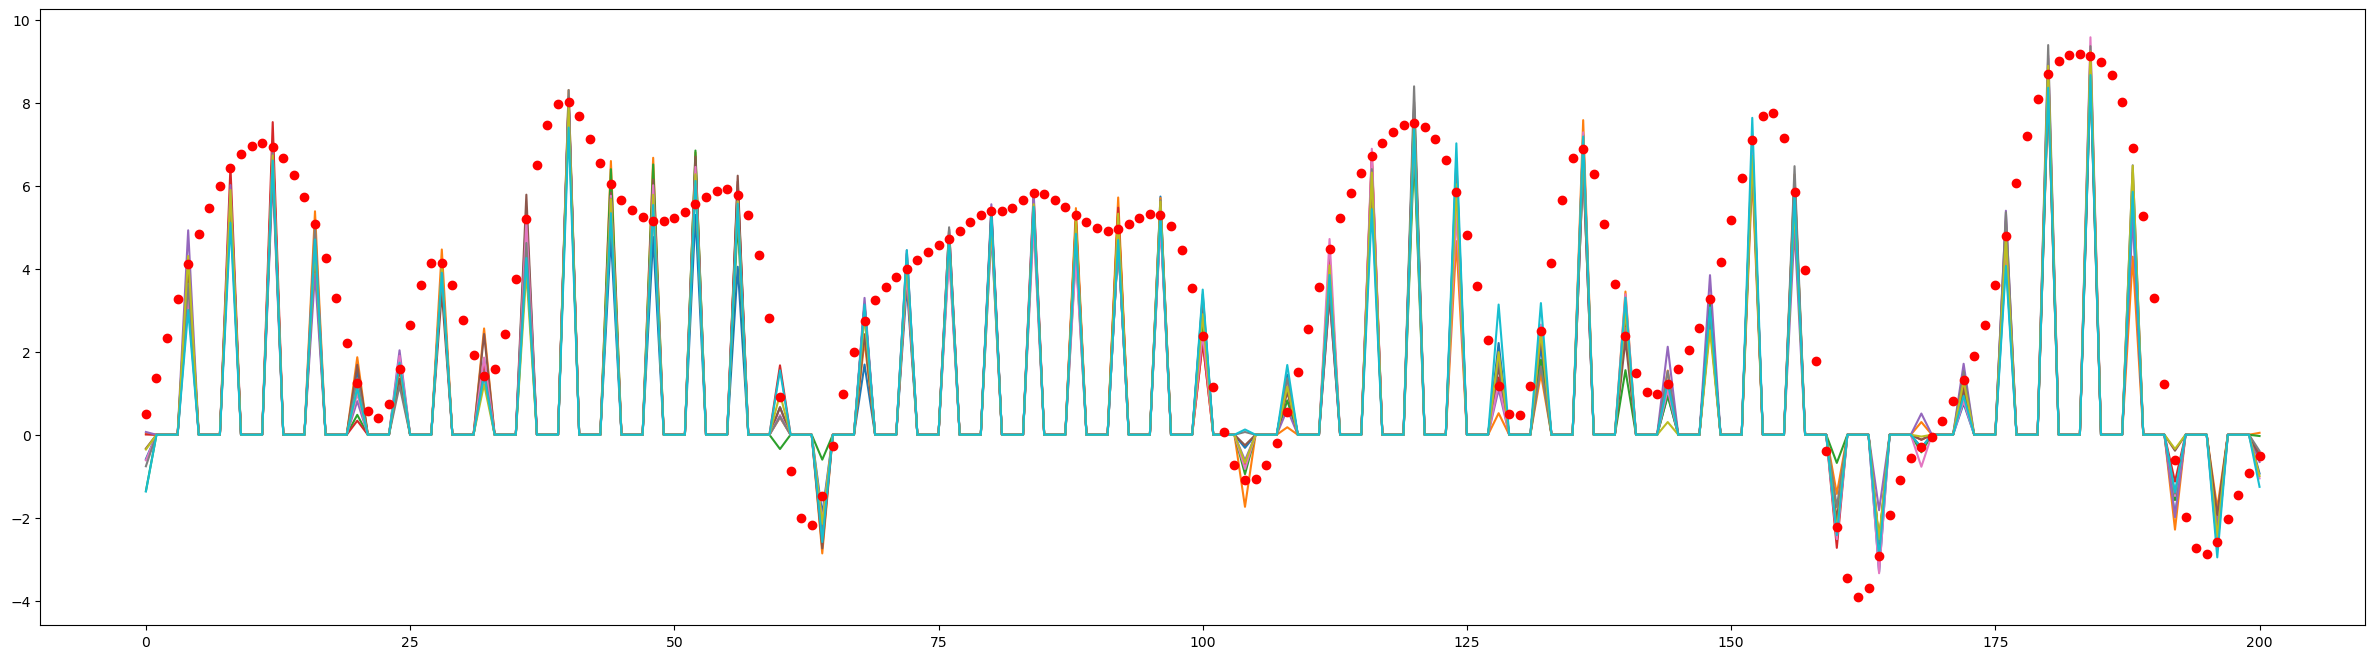

In [21]:
import matplotlib.pyplot as plt
plt.plot(Xa_history[1100:1301,20,:])
plt.plot(x_nature[20,1100:1301], linestyle = 'None', marker = 'o', color = 'r')
plt.rcParams['figure.figsize'] = [30/1, 8/1]

In [22]:
threshold = sv.load('extreme_threshold.txt') 
threshold

14.216876519713022

In [23]:
#t 0.05 = 6 hour
trial = 6
rk = 1.0
base_norm  = 0.1989 #the 100 years averaged 6-h analysis rmse
norm = rk*base_norm
inter_step = 5
days_before = 4
times_of_6h = 4 # Qiwen add 2021/10/26
obs_error_std = 1
untouch_state = [] #random.sample(range(40),10)

t_start = 1000
position = int((days_before * 24)/6 + 1e-6) # 1 position store each 6-hour observation

Xa_initial = Xa_history[t_start, :, :]
Xa_initial = np.matrix(Xa_initial)

x_original = x_nature[:,t_start]
experiment_step = 146000
evo_history = np.zeros((xdim, experiment_step * inter_step + 1))
evo_history[:,0]=x_original

t = np.arange(0, position * 0.01 * inter_step + 0.001, 0.01)
t_output = t

t_conti = np.arange(0, 0.01 * inter_step * times_of_6h + 0.001, 0.01) # Qiwen modified 2021/10/26
t_conti_output = np.arange(0.01, 0.01 * inter_step * times_of_6h + 0.001, 0.01) # Qiwen modified 2021/10/26

xf_4d_box= np.zeros((das.edim , das.xdim, len(t)))

#lb = max(glo_extreme_series[0,0:int(len(glo_extreme_series[0,:])/2 + 1e-6)])
#ub = min(glo_extreme_series[0,int(len(glo_extreme_series[0,:])/2 + 1e-6):])
ub = threshold

smd = LORENZ96(N = 40, F = 8)
perturbed = False

Xa_history_control = np.zeros((experiment_step +1, das.xdim, das.edim))# Qiwen modified 2021/10/26
Xa_history_control[0, :, :] = Xa_initial

perturbed_time = []
success_perturbed_time = []
false_alarm_perturbed_time = []

#no_ch_bkp = np.zeros((experiment_step, das.xdim, das.edim))
no_ch_bkp = np.zeros((das.edim, das.xdim, len(t)))

control_t_all = []
fa_control_t_all = []
s_control_t_all = []

ready =0

fa_fcst_err_all = []
fa_fcst_sprd_all = []
fa_ana_err_all = []
s_fcst_err_all = []
s_fcst_sprd_all = []
s_ana_err_all = []
f_fcst_err_all = []
f_fcst_sprd_all = []
f_ana_err_all = []
np_fcst_err_all = []
np_fcst_sprd_all = []
np_ana_err_all = []

fcst_err_hist = np.zeros((experiment_step,position+1))  
ana_err_hist = np.zeros((experiment_step,position+1))   
fcst_sprd_hist = np.zeros((experiment_step,position+1)) 
ana_sprd_hist = np.zeros((experiment_step,position+1))  
fail_c = 0
perturbation_all_history = np.zeros((xdim, experiment_step * inter_step + 1)) #20210704
for time in range(0,experiment_step, times_of_6h): # Qiwen modified 2021/10/26
    print(time)
    #if not all(item > lb and item < ub for item in (evo_history[:,(time-1)*inter_step+1:time * inter_step+1]).flatten()):
    if time>0:
        if max((evo_history[:,(time-times_of_6h)*inter_step+1:time * inter_step+1]).flatten())>ub: # Qiwen modified 2021/10/26
            cant_control = True
            print('fail control')
            fail_c = fail_c + 1
            #break
    amp = 1/norm
    change_ens = []
    unchange_ens = []
    p_change = 0
    if perturbed or time ==0:
        evol = smd.run_rk4(t[0],t[-1],dt,x_original)
        evol = evol[::2,:]
        evol = evol.T
        if perturbed and not false_alarm:
            #if all(item > lb and item < ub for item in (evol[:,0:-inter_step]).flatten()):
            if max((evol[:,0:-(inter_step*times_of_6h)]).flatten())<ub: # Qiwen modified 2021/10/26
                success_perturbed_time = np.hstack((success_perturbed_time,np.arange((time-times_of_6h)*inter_step + 1, (time)*inter_step)))
    else:
        evol_conti = smd.run_rk4(t_conti[0], t_conti[-1], dt, evol[:,-1])
        evol_conti = evol_conti[2::2,:]
        evol_conti = evol_conti.T
        evol = np.hstack((evol[:,inter_step*times_of_6h:], evol_conti)) # Qiwen modified 2021/10/26
    ex_find = False
    for k in range(das.edim):
        xf_ens = smd.run_rk4(t[0], t[-1], dt, Xa_initial[:,k].A1)
        xf_ens = xf_ens[::2,:]
        xf_ens = xf_ens.T
        #if all(item > lb and item < ub for item in (xf_ens[:,:]).flatten()):
        if max((xf_ens[:,:]).flatten())<ub:
            unchange_ens.append(k)
            #no_ch_bkp[time, :,k]= xf_ens[:,0]
            no_ch_bkp[k,:,:]= xf_ens
        else:
            ex_find = True
            change_ens.append(k)
            p_change = p_change + 1
           
        xf_4d_box[k,:,:] = xf_ens
    #ex_num = 0
    if ex_find:
        extreme_loc = np.where(xf_4d_box == xf_4d_box.max())
    '''
    if xf_4d_box.min() < lb:
        ex_num = ex_num + 1
        extreme_loc = np.where(xf_4d_box == xf_4d_box.min())
        ex_l = np.where(xf_4d_box == xf_4d_box.min())
        #print('l extreme = ', xf_4d_box[extreme_loc])
    if ex_num >1:
        if ex_u[2] >=ex_l[2]:
            extreme_loc = np.where(xf_4d_box == xf_4d_box.min())
        else:
            extreme_loc = np.where(xf_4d_box == xf_4d_box.max())
        print('WHAT!')
        #break
    '''
    
    if p_change < das.edim and p_change > 0:
        false_alarm = False
        perturbed = True
        perturbed_time = np.hstack((perturbed_time,np.arange(time*inter_step + 1, (time+ times_of_6h)*inter_step))) # Qiwen modified 2021/10/26

        #if all(item > lb and item < ub for item in (evol[:,:]).flatten()):
        if max((evol[:,:]).flatten()) < ub:
            false_alarm = True
            false_alarm_perturbed_time = np.hstack((false_alarm_perturbed_time,np.arange(time*inter_step + 1, (time+times_of_6h)*inter_step))) # Qiwen modified 2021/10/26
        else:
            draw = True

        #perturbation_all = xf_4d_box[np.random.choice(unchange_ens),:,1:inter_step]-xf_4d_box[np.random.choice(change_ens),:,1:inter_step]
        p = np.where(abs(xf_4d_box[unchange_ens,extreme_loc[1],extreme_loc[2]] - xf_4d_box[extreme_loc]) == abs(xf_4d_box[unchange_ens,extreme_loc[1],extreme_loc[2]] - xf_4d_box[extreme_loc]).max())
        
        perturbation_all = xf_4d_box[unchange_ens[p[0][0]],:,1:inter_step*times_of_6h] - xf_4d_box[extreme_loc[0],:,1:inter_step*times_of_6h] # Qiwen modified 2021/10/26
        
        perturbation_all = perturbation_all[0,:,:]
        
        perturbation_all[untouch_state,:]=0
        perturbation_vector = perturbation_all/(amp*np.linalg.norm(perturbation_all,axis = 0))
        perturbation_all_history[:,time*inter_step+1:(time+times_of_6h)*inter_step] = perturbation_vector # Qiwen modified 2021/10/26
        x_original_gen = smd.run_rk4(0,0.01, dt, x_original)
        x_original_gen = x_original_gen[::2,:]
        x_original_gen = x_original_gen.T
        x_original = x_original_gen[:,1]
        for q in range(inter_step*times_of_6h-1): # Qiwen modified 2021/10/26
            x_perturbed_ini = x_original + perturbation_vector[:,q]
            evo_history[:,time * inter_step + q + 1] = x_perturbed_ini
            perturbed_nature_evo = smd.run_rk4(0,0.01, dt, x_perturbed_ini)
            perturbed_nature_evo = perturbed_nature_evo[::2,:]
            perturbed_nature_evo = perturbed_nature_evo.T
            x_original = perturbed_nature_evo[:,1]
        evo_history[:, (time+times_of_6h) * inter_step] = x_original # Qiwen modified 2021/10/26
        
        fcst_err = np.sqrt(np.mean(np.square(np.mean(xf_4d_box[:,:,::inter_step], axis = 0) - evol[:,::inter_step]), axis=0))
        fcst_sprd = np.mean(np.std(xf_4d_box[:,:,::inter_step], axis = 0), axis = 0)
        fcst_sprd_hist[time] = fcst_sprd
        fcst_err_hist[time]=fcst_err

        obs = x_original + np.random.normal(0,obs_error_std,das.xdim)
        
        local = 19
        yo_loc = np.zeros(2*local+1)
        #Xb_loc = np.zeros((2*local+1,das.edim))
        Yb_loc = np.zeros((2*local+1,das.edim))
        ym_loc = np.zeros((2*local+1,1))
        #xm_loc = np.zeros((2*local+1,1))

        Yb = np.dot(H,xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T) # Qiwen modified 2021/10/26
        yo = np.matrix(obs).flatten().T
        ym = np.mean(Yb, axis = 1)
        xm = np.mean(xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T,axis=1) # Qiwen modified 2021/10/26
        Xb = xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T - np.matlib.repmat(xm, das.edim,1).T # Qiwen modified 2021/10/26
        Yb = Yb - np.matlib.repmat(ym, das.edim, 1).T 
        Xa = np.zeros((xdim,das.edim))

        for b in range(xdim):
            ind = np.arange(b-local,b+local+1)
            ind = (ind + 40)%40
            nn = 0
            for bb in ind:
                yo_loc[nn] = obs[bb]
                #Xb_loc[nn,:] = Xb[bb,:]
                Yb_loc[nn,:] = Yb[bb,:]
                ym_loc[nn] = ym[bb]
                #xm_loc[nn] = xm[bb]
                nn = nn + 1
            Xb_loc = Xb[b,:]
            xm_loc = xm[b]
            Xa_loc, KH_loc = das.compute_analysis(Xb_loc,yo_loc,Yb_loc,ym_loc,xm_loc)
            Xa[b,:] = Xa_loc
        Xa = np.matrix(Xa)

        #Xa, KH = das.compute_analysis(xf_4d_box[0:das.edim,:,inter_step].T,obs)
        Xa_history_control[time+times_of_6h,:,:] = Xa # Qiwen modified 2021/10/26
        Xa_initial = Xa 
        Xa_initial = np.matrix(Xa_initial)
        
    elif p_change < 1:
        per_times = 0
        perturbed = False

        evo_history[:, time * inter_step + 1 : (time + times_of_6h) * inter_step + 1] = evol[:,1:inter_step*times_of_6h+1]# Qiwen modified 2021/10/26
        x_original = evol[:,inter_step*times_of_6h] # Qiwen modified 2021/10/26

        fcst_err = np.sqrt(np.mean(np.square(np.mean(xf_4d_box[:,:,::inter_step], axis = 0) - evol[:,::inter_step]), axis=0))
        fcst_sprd = np.mean(np.std(xf_4d_box[:,:,::inter_step], axis = 0), axis = 0)
        fcst_sprd_hist[time] = fcst_sprd
        fcst_err_hist[time]=fcst_err

        obs = x_original + np.random.normal(0,obs_error_std,das.xdim)
        
        local = 19
        yo_loc = np.zeros(2*local+1)
        #Xb_loc = np.zeros((2*local+1,das.edim))
        Yb_loc = np.zeros((2*local+1,das.edim))
        ym_loc = np.zeros((2*local+1,1))
        #xm_loc = np.zeros((2*local+1,1))

        Yb = np.dot(H,xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T) # Qiwen modified 2021/10/26
        yo = np.matrix(obs).flatten().T
        ym = np.mean(Yb, axis = 1)
        xm = np.mean(xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T,axis=1) # Qiwen modified 2021/10/26
        Xb = xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T - np.matlib.repmat(xm, das.edim,1).T # Qiwen modified 2021/10/26
        Yb = Yb - np.matlib.repmat(ym, das.edim,1).T
        Xa = np.zeros((xdim,das.edim))

        for b in range(xdim):
            ind = np.arange(b-local,b+local+1)
            ind = (ind + 40)%40
            nn = 0
            for bb in ind:
                yo_loc[nn] = obs[bb]
                #Xb_loc[nn,:] = Xb[bb,:]
                Yb_loc[nn,:] = Yb[bb,:]
                ym_loc[nn] = ym[bb]
                #xm_loc[nn] = xm[bb]
                nn = nn + 1
            Xb_loc = Xb[b,:]
            xm_loc = xm[b]
            Xa_loc, KH_loc = das.compute_analysis(Xb_loc,yo_loc,Yb_loc,ym_loc,xm_loc)
            Xa[b,:] = Xa_loc
        Xa = np.matrix(Xa)

        Xa_history_control[time+ times_of_6h,:,:] = Xa # Qiwen modified 2021/10/26
        Xa_initial = Xa 
        Xa_initial = np.matrix(Xa_initial)
    else:
        print('search history')
        false_alarm = False
        perturbed = True
        perturbed_time = np.hstack((perturbed_time,np.arange(time*inter_step + 1, (time+times_of_6h)*inter_step))) # Qiwen modified 2021/10/26
        #if all(item > lb and item < ub for item in (evol[:,:]).flatten()):
        if max((evol[:,:]).flatten()) < ub:
            false_alarm = True
            false_alarm_perturbed_time = np.hstack((false_alarm_perturbed_time,np.arange(time*inter_step + 1, (time+ times_of_6h)*inter_step)))# Qiwen modified 2021/10/26
        
        if time == 0:
            find = False
            for l in range(times_of_6h, t_start, times_of_6h): # Qiwen modified 2021/10/26
                Xa_before = Xa_hisory[t_start-l, :, :]
                Xa_before = np.matrix(Xa_before)
                t_b = np.arange(0, l * inter_step * 0.01 + position * 0.01 * inter_step + 0.001, 0.01)
                #t_b_output = t_b[l*inter_step+1:]
                for v in range(das.edim):
                    xf_ens = smd.run_rk4(t_b[0], t_b[-1], dt, Xa_before[:,v].A1)
                    xf_ens = xf_ens[2*(l*inter_step+1)::2,:]
                    xf_ens = xf_ens.T

                    #if all(item > lb and item < ub for item in (xf_ens[:,:]).flatten()):
                    if max((xf_ens[:,:]).flatten()) < ub:
                        find = True
                        #perturbation_all = xf_ens[:,0:inter_step-1] - xf_4d_box[np.random.choice(change_ens),:,1:inter_step]
                        perturbation_all = xf_ens[:,0:inter_step*times_of_6h-1] - xf_4d_box[extreme_loc[0],:,1:inter_step*times_of_6h][0] # Qiwen modified 2021/10/26
                        #perturbation_all = perturbation_all[0,:,:]
                        perturbation_all[untouch_state,:]=0
                        perturbation_vector = perturbation_all/(amp*np.linalg.norm(perturbation_all,axis = 0))
                        perturbation_all_history[:,time*inter_step+1:(time+times_of_6h)*inter_step] = perturbation_vector # Qiwen modified 2021/10/26
                        
                        x_original_gen = smd.run_rk4(0,0.01, dt, x_original)
                        x_original_gen = x_original_gen[::2,:]
                        x_original_gen = x_original_gen.T
                        x_original = x_original_gen[:,1]
                        for q in range(inter_step*times_of_6h-1):
                            x_perturbed_ini = x_original + perturbation_vector[:,q]
                            evo_history[:, time * inter_step + q + 1] = x_perturbed_ini
                            perturbed_nature_evo = smd.run_rk4(0,0.01, dt, x_perturbed_ini)
                            perturbed_nature_evo = perturbed_nature_evo[::2,:]
                            perturbed_nature_evo = perturbed_nature_evo.T
                            x_original = perturbed_nature_evo[:,1]
                        evo_history[:, (time+times_of_6h) * inter_step] = x_original
                        
                        fcst_err = np.sqrt(np.mean(np.square(np.mean(xf_4d_box[:,:,::inter_step], axis = 0) - evol[:,::inter_step]), axis=0))
                        fcst_sprd = np.mean(np.std(xf_4d_box[:,:,::inter_step], axis = 0), axis = 0)
                        fcst_sprd_hist[time] = fcst_sprd
                        fcst_err_hist[time]=fcst_err
                        
                        obs = x_original + np.random.normal(0,obs_error_std,das.xdim)
                        local = 19
                        yo_loc = np.zeros(2*local+1)
                        Yb_loc = np.zeros((2*local+1,das.edim))
                        ym_loc = np.zeros((2*local+1,1))

                        Yb = np.dot(H,xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T) # Qiwen modified 2021/10/26
                        yo = np.matrix(obs).flatten().T
                        ym = np.mean(Yb, axis = 1)
                        xm = np.mean(xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T,axis=1) # Qiwen modified 2021/10/26
                        Xb = xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T - np.matlib.repmat(xm, das.edim,1).T # Qiwen modified 2021/10/26
                        Yb = Yb - np.matlib.repmat(ym, das.edim,1).T
                        Xa = np.zeros((xdim,das.edim))

                        for b in range(xdim):
                            ind = np.arange(b-local,b+local+1)
                            ind = (ind + 40)%40
                            nn = 0
                            for bb in ind:
                                yo_loc[nn] = obs[bb]
                                Yb_loc[nn,:] = Yb[bb,:]
                                ym_loc[nn] = ym[bb]
                                nn = nn + 1
                            Xb_loc = Xb[b,:]
                            xm_loc = xm[b]
                            Xa_loc, KH_loc = das.compute_analysis(Xb_loc,yo_loc,Yb_loc,ym_loc,xm_loc)
                            Xa[b,:] = Xa_loc
                        Xa = np.matrix(Xa)
                        Xa_history_control[time+times_of_6h,:,:] = Xa # Qiwen modified 2021/10/26
                        Xa_initial = Xa  
                        Xa_initial = np.matrix(Xa_initial)
                        break
                if find:
                    break
                if not find and l == (t_start - 200*times_of_6h):
                        sys.exit("Can't find any good perturbation")
        else:                           
            #for s in range(1,time + (t_start - position),1):
            for s in range(times_of_6h,time + t_start,times_of_6h): # Qiwen modified 2021/10/26
               if s > time:
                   find = False
                   #for l in range(1, t_start - position, 1):
                   #Xa_before = Xa_history[(t_start - position) - (s-time), :, :]
                   Xa_before = Xa_history[t_start - (s-time), :, :]
                   Xa_before = np.matrix(Xa_before)
                   t_b = np.arange(0, 0.01 * inter_step * (position +  s) + 0.001, 0.01)
                   t_b_output = t_b[s * inter_step + 1:]
                   for v in range(das.edim):
                        xf_ens = smd.run_rk4(t_b[0], t_b[-1], dt, Xa_before[:,v].A1)
                        xf_ens = xf_ens[2*(s * inter_step + 1)::2,:]
                        xf_ens = xf_ens.T
                        #if all(item > lb and item < ub for item in (xf_ens[:,:]).flatten()):
                        if max((xf_ens[:,:]).flatten()) < ub:
                            find = True
                            #perturbation_all = xf_ens[:,0:inter_step-1] - xf_4d_box[np.random.choice(change_ens),:,1:inter_step]
                            perturbation_all = xf_ens[:,0:inter_step*times_of_6h-1] - xf_4d_box[extreme_loc[0],:,1:inter_step*times_of_6h][0] # Qiwen modified 2021/10/26
                            perturbation_all[untouch_state,:]=0
                            perturbation_vector = perturbation_all/(amp*np.linalg.norm(perturbation_all,axis = 0))
                            perturbation_all_history[:,time*inter_step+1:(time+times_of_6h)*inter_step] = perturbation_vector # Qiwen modified 2021/10/26
                            
                            x_original_gen = smd.run_rk4(0,0.01, dt, x_original)
                            x_original_gen = x_original_gen[::2,:]
                            x_original_gen = x_original_gen.T
                            x_original = x_original_gen[:,1]
                            for q in range(inter_step*times_of_6h-1): # Qiwen modified 2021/10/26
                                x_perturbed_ini = x_original + perturbation_vector[:,q]
                                evo_history[:, time * inter_step + q + 1] = x_perturbed_ini
                                perturbed_nature_evo = smd.run_rk4(0,0.01, dt, x_perturbed_ini)
                                perturbed_nature_evo = perturbed_nature_evo[::2,:]
                                perturbed_nature_evo = perturbed_nature_evo.T
                                x_original = perturbed_nature_evo[:,1]
                            evo_history[:, (time+times_of_6h) * inter_step] = x_original
                           
                            fcst_err = np.sqrt(np.mean(np.square(np.mean(xf_4d_box[:,:,::inter_step], axis = 0) - evol[:,::inter_step]), axis=0))
                            fcst_sprd = np.mean(np.std(xf_4d_box[:,:,::inter_step], axis = 0), axis = 0)
                            fcst_sprd_hist[time] = fcst_sprd
                            fcst_err_hist[time]=fcst_err
                           
                            obs = x_original + np.random.normal(0,obs_error_std,das.xdim)
                            local = 19
                            yo_loc = np.zeros(2*local+1)
                            Yb_loc = np.zeros((2*local+1,das.edim))
                            ym_loc = np.zeros((2*local+1,1))

                            Yb = np.dot(H,xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T) # Qiwen modified 2021/10/26
                            yo = np.matrix(obs).flatten().T
                            ym = np.mean(Yb, axis = 1)
                            xm = np.mean(xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T,axis=1) # Qiwen modified 2021/10/26
                            Xb = xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T - np.matlib.repmat(xm, das.edim,1).T # Qiwen modified 2021/10/26
                            Yb = Yb - np.matlib.repmat(ym, das.edim,1).T
                            Xa = np.zeros((xdim,das.edim))

                            for b in range(xdim):
                                ind = np.arange(b-local,b+local+1)
                                ind = (ind + 40)%40
                                nn = 0
                                for bb in ind:
                                    yo_loc[nn] = obs[bb]
                                    Yb_loc[nn,:] = Yb[bb,:]
                                    ym_loc[nn] = ym[bb]
                                    nn = nn + 1
                                Xb_loc = Xb[b,:]
                                xm_loc = xm[b]
                                Xa_loc, KH_loc = das.compute_analysis(Xb_loc,yo_loc,Yb_loc,ym_loc,xm_loc)
                                Xa[b,:] = Xa_loc
                            Xa = np.matrix(Xa)
                            Xa_history_control[time+times_of_6h,:,:] = Xa
                            Xa_initial = Xa
                            Xa_initial = np.matrix(Xa_initial)
                            break
                   if find:
                        break
                   #elif not find and s== time + (t_start - position)-1:
                   elif not find and s== time + (t_start)-times_of_6h: # Qiwen modified 2021/10/26
                        sys.exit("Can't find any good perturbation")
               else:
                    find = False
                    for w in range(das.edim):
                        t_help = np.arange(0, 0.01 * inter_step * (position +  s) + 0.001, 0.01)
                        t_help_output = t_help[s*inter_step +1:]
                        uc_help = smd.run_rk4(t_help[0], t_help[-1], dt,Xa_history_control[time-s,:, w])
                        uc_help = uc_help[2*(s*inter_step +1)::2,:]
                        uc_help =uc_help.T
                        #if all(item > lb and item < ub for item in (uc_help[:,:]).flatten()):
                        if max((uc_help[:,:]).flatten())<ub:
                            find = True
                            #perturbation_all = uc_help[:,0:inter_step-1] - xf_4d_box[np.random.choice(change_ens),:,1:inter_step]
                            perturbation_all = uc_help[:,0:inter_step*times_of_6h-1] - xf_4d_box[extreme_loc[0],:,1:inter_step*times_of_6h][0] # Qiwen modified 2021/10/26
                            perturbation_all[untouch_state,:]=0
                            perturbation_vector = perturbation_all/(amp*np.linalg.norm(perturbation_all,axis = 0))
                            perturbation_all_history[:,time*inter_step+1:(time+times_of_6h)*inter_step] = perturbation_vector # Qiwen modified 2021/10/26

                            x_original_gen = smd.run_rk4(0,0.01, dt, x_original)
                            x_original_gen = x_original_gen[::2,:]
                            x_original_gen = x_original_gen.T
                            x_original = x_original_gen[:,1]
                            
                            for q in range(inter_step*times_of_6h-1): # Qiwen modified 2021/10/26
                                x_perturbed_ini = x_original + perturbation_vector[:,q]
                                evo_history[:, time * inter_step + q + 1] = x_perturbed_ini
                                perturbed_nature_evo = smd.run_rk4(0,0.01, dt, x_perturbed_ini)
                                perturbed_nature_evo = perturbed_nature_evo[::2,:]
                                perturbed_nature_evo = perturbed_nature_evo.T
                                x_original = perturbed_nature_evo[:,1]
                            evo_history[:, (time+times_of_6h) * inter_step] = x_original
                            
                            fcst_err = np.sqrt(np.mean(np.square(np.mean(xf_4d_box[:,:,::inter_step], axis = 0) - evol[:,::inter_step]), axis=0))
                            fcst_sprd = np.mean(np.std(xf_4d_box[:,:,::inter_step], axis = 0), axis = 0)
                            fcst_sprd_hist[time] = fcst_sprd
                            fcst_err_hist[time]=fcst_err
                            
                            obs = x_original + np.random.normal(0,obs_error_std,das.xdim)
                            local = 19
                            yo_loc = np.zeros(2*local+1)
                            Yb_loc = np.zeros((2*local+1,das.edim))
                            ym_loc = np.zeros((2*local+1,1))

                            Yb = np.dot(H,xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T) # Qiwen modified 2021/10/26
                            yo = np.matrix(obs).flatten().T
                            ym = np.mean(Yb, axis = 1)
                            xm = np.mean(xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T,axis=1) # Qiwen modified 2021/10/26
                            Xb = xf_4d_box[0:das.edim,:,inter_step*times_of_6h].T - np.matlib.repmat(xm, das.edim,1).T # Qiwen modified 2021/10/26
                            Yb = Yb - np.matlib.repmat(ym, das.edim,1).T
                            Xa = np.zeros((xdim,das.edim))

                            for b in range(xdim):
                                ind = np.arange(b-local,b+local+1)
                                ind = (ind + 40)%40
                                nn = 0
                                for bb in ind:
                                    yo_loc[nn] = obs[bb]
                                    Yb_loc[nn,:] = Yb[bb,:]
                                    ym_loc[nn] = ym[bb]
                                    nn = nn + 1
                                Xb_loc = Xb[b,:]
                                xm_loc = xm[b]
                                Xa_loc, KH_loc = das.compute_analysis(Xb_loc,yo_loc,Yb_loc,ym_loc,xm_loc)
                                Xa[b,:] = Xa_loc
                            Xa = np.matrix(Xa)
                            Xa_history_control[time+times_of_6h,:,:] = Xa
                            Xa_initial = Xa
                            Xa_initial = np.matrix(Xa_initial)
                            break
                    if find:
                        break

0
4
8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84


KeyboardInterrupt: 

In [67]:
print(trial, rk, days_before)

6 1.0 4


In [68]:
fail_c

2

In [69]:
ttt = 0
for i in range(146000):
    if max((evo_history[:,i*inter_step:(i+1)*inter_step]).flatten())>threshold:
        ttt = ttt+1
ttt

3

In [70]:
np.sum(abs(perturbation_all_history))

14971.421767552605

In [71]:
with open("24_h_per_k%s_%sday%s.txt"%(rk, days_before, trial), "wb") as fp:
            pickle.dump(perturbation_all_history, fp)
with open("24_h_evol_k%s_%sday%s.txt"%(rk, days_before, trial), "wb") as fp:
            pickle.dump(evo_history, fp)

In [72]:
control_t_all.append((len(perturbed_time)/(inter_step*times_of_6h-1))) # Qiwen modified 2021/10/26
fa_control_t_all.append(len(false_alarm_perturbed_time)/(inter_step*times_of_6h-1)) # Qiwen modified 2021/10/26
s_control_t_all.append(len(success_perturbed_time)/(inter_step*times_of_6h-1)) # Qiwen modified 2021/10/26
print(control_t_all[0])
print(fa_control_t_all[0]) 
print(s_control_t_all[0])
print(control_t_all[0]-fa_control_t_all[0]-s_control_t_all[0])

if len(false_alarm_perturbed_time[0::inter_step*times_of_6h-1]) == 0: # Qiwen modified 2021/10/26
    fa = []
else:
    fa = ((false_alarm_perturbed_time[0::inter_step*times_of_6h-1]-1)//inter_step).astype(int) # Qiwen modified 2021/10/26

if len(success_perturbed_time[0::inter_step*times_of_6h-1]) == 0: # Qiwen modified 2021/10/26
    ss = []
else:
    ss = ((success_perturbed_time[0::inter_step*times_of_6h-1]-1)//inter_step).astype(int) # Qiwen modified 2021/10/26



ff = (((np.sort(np.array(list(set(perturbed_time) - set(false_alarm_perturbed_time) -
                      set(success_perturbed_time))))[0::inter_step*times_of_6h-1])-1)//inter_step).astype(int) # Qiwen modified 2021/10/26

nop = (np.array(list(set(np.arange(0,experiment_step,times_of_6h)) - set(fa) - set(ss) -set(ff)))).astype(int) # Qiwen modified 2021/10/26
count =0
if count > 1 and ready == 1:
    fa_fcst_err_all = np.vstack((fa_fcst_err_all,fcst_err_hist[fa]))
    s_fcst_err_all = np.vstack((s_fcst_err_all,fcst_err_hist[ss]))
    f_fcst_err_all = np.vstack((f_fcst_err_all,fcst_err_hist[ff]))
    np_fcst_err_all = np.vstack((np_fcst_err_all,fcst_err_hist[nop]))
    fa_fcst_sprd_all = np.vstack((fa_fcst_sprd_all,fcst_sprd_hist[fa]))
    s_fcst_sprd_all = np.vstack((s_fcst_sprd_all,fcst_sprd_hist[ss]))
    f_fcst_sprd_all = np.vstack((f_fcst_sprd_all,fcst_sprd_hist[ff]))
    np_fcst_sprd_all = np.vstack((np_fcst_sprd_all,fcst_sprd_hist[nop]))
else:
    ready = 1
    fa_fcst_err_all = fcst_err_hist[fa]
    s_fcst_err_all = fcst_err_hist[ss]
    f_fcst_err_all = fcst_err_hist[ff]
    np_fcst_err_all = fcst_err_hist[nop]
    fa_fcst_sprd_all = fcst_sprd_hist[fa]
    s_fcst_sprd_all = fcst_sprd_hist[ss]
    f_fcst_sprd_all = fcst_sprd_hist[ff]
    np_fcst_sprd_all = fcst_sprd_hist[nop]


824.0
752.0
69.0
3.0


In [73]:
#save the perturb time respectively
with open("24_h_fcst_per_time_%s_%sday%s.txt"%(int(rk*10+1e-6), days_before, trial), "wb") as fp:
        pickle.dump(perturbed_time, fp)
with open("24_h_fcst_fa_per_time_%s_%sday%s.txt"%(int(rk*10+1e-6), days_before, trial), "wb") as fp:
        pickle.dump(false_alarm_perturbed_time, fp)
with open("24_h_fcst_s_per_time_%s_%sday%s.txt"%(int(rk*10+1e-6), days_before, trial), "wb") as fp:
        pickle.dump(success_perturbed_time, fp)

In [74]:
#put all kinds of forecast error / spread together
err_coll = np.vstack((np.mean(fa_fcst_err_all,axis = 0),np.mean(s_fcst_err_all,axis =0), 
           np.mean(f_fcst_err_all, axis = 0),np.mean(np_fcst_err_all,axis =0)))
sprd_coll = np.vstack((np.mean(fa_fcst_sprd_all,axis = 0),np.mean(s_fcst_sprd_all,axis =0), 
           np.mean(f_fcst_sprd_all, axis = 0),np.mean(np_fcst_sprd_all,axis =0)))
err_sprrd_coll = np.vstack((err_coll,sprd_coll))

In [75]:
#save the fcst error / sprd
with open("24_h_fcst_er_spr_%s_%sday%s.txt"%(int(rk*10+1e-6),days_before, trial), "wb") as fp:
        pickle.dump(err_sprrd_coll, fp)

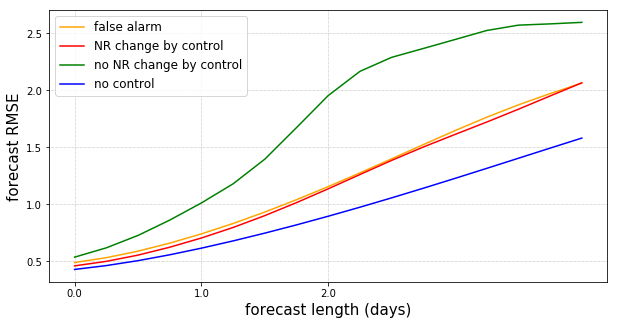

In [76]:
#draw the forecast error and spread for different situation
color = ['orange', 'red', 'green', 'blue']
label = ['false alarm', 'NR change by control', 'no NR change by control', 'no control']
plt.figure(figsize=(10,5))
for i in range(len(err_coll)):
    plt.plot(err_coll[i,:], color = color[i], label = label[i])
    #plt.plot(sprd_coll[i,:], color = color[i], label = label[i], linestyle='dashed')
plt.grid(color = 'grey', linestyle = ':', linewidth =0.5)
plt.xlabel('forecast length (days)', fontsize = 15)
plt.ylabel('forecast RMSE', fontsize = 15)
plt.xticks(np.arange(0,9,4), np.arange(0,2.1,1))
plt.legend(loc = 'best', fontsize = 12)
plt.savefig('24h_fcst_err_%s_%sday_trial%s'%(int(10*rk+1e-6),days_before, trial), bbox_inches = 'tight')

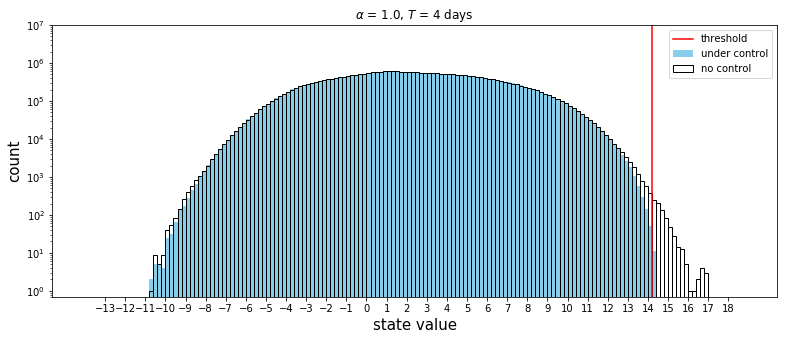

In [77]:
full_nature = sv.getTrajectory()
full_nature_flatten = full_nature.flatten()
evo_history_flatten = evo_history[:,:].flatten()
plt.figure(figsize = (13,5))
plt.hist(evo_history_flatten, bins = np.arange(-14,19,0.2),log = True, density = False, facecolor = 'skyblue', label = 'under control')
plt.hist(full_nature_flatten, bins = np.arange(-14,19,0.2),log = True, density = False, edgecolor = 'k', facecolor = 'None', label ='no control')
plt.xticks(np.arange(-13,19,1))
plt.ylim(1e0 - 0.3,1e7)
plt.axvline(x=threshold,color = 'r', label='threshold')
plt.xlabel('state value', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.legend(loc='best')
plt.title(r'$\alpha$ = %s, $T$ = %s days'%(rk,days_before))
plt.savefig('24h_after_control_hist_%s_%sday_trial%s'%(int(10*rk+1e-6),days_before,trial), bbox_inches = 'tight')
plt.show()


In [2]:
a = (np.mean(Xa_history[::4,:,:], axis = 2) - x_nature[:,::4].T)

In [3]:
b =np.sqrt((np.sum(np.square(a),axis = 1))/40)

In [4]:
np.mean(b)

0.4219192536569569

In [5]:
sprd=[]
for i in range(0,146001,4):
    sprd.append(np.mean(np.std(Xa_history[i,:,:], axis = 1)))
np.mean(sprd)

0.3885130021746001